In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
import missingno as msno
# from pandas_profiling import ProfileReport
# https://stackoverflow.com/questions/64137932/create-interaction-term-in-scikit-learn

In [2]:
parentdir = os.getcwd()
testdata = pd.read_excel('Human Training and Testing sets for model.xlsx', sheet_name='Human Testing')
traindata = pd.read_excel('Human Training and Testing sets for model.xlsx', sheet_name='Human Training')
Full = pd.concat([testdata, traindata ]).reset_index()
Full.to_csv('Concatenated_RAW.txt', sep='\t')

In [3]:
Full.isna().sum()
Full.dropna(inplace=True)

### grouping Data
* finding average values from technical replicates. (Decided to use whole data and not average). 
* dropping whole cell lysate as it is not informative to antigens present for Burk infection.

In [4]:
# group = Full.groupby(['PatientID', 'SerumID', 'TimeGroup', 'Status', 'Type']).mean().reset_index()
Clean = Full.drop(['MSHR5855.WCL'], axis=1)
for name, group in Clean.groupby("Type"):
    print(name)
    print(Clean.Status.value_counts())

for name, group in group.groupby("Type"):
    print(name)
    print(Clean.TimeGroup.value_counts())

IgG
Negative    1436
Melioid     1428
Name: Status, dtype: int64
IgM
Negative    1436
Melioid     1428
Name: Status, dtype: int64
IgM
Healthy    1436
Week4+      963
Week2       180
Week3       163
Week1       106
Prior        16
Name: TimeGroup, dtype: int64


In [4]:
if not os.path.isdir('NonResampled'):
    os.makedirs('NonResampled')
os.chdir('NonResampled')
parentdir = os.getcwd()

for name, group in Clean.groupby("Type"): # add SerumID to group
    print(name)
    os.chdir(parentdir)
    if not os.path.isdir(name):
        os.makedirs(name)
    os.chdir(name)
    TypeDir = os.getcwd()
    if not os.path.isdir('ValidationSet'):
        os.makedirs('ValidationSet')
    os.chdir('ValidationSet')
    
    Week4 = group.loc[(group['TimeGroup']=='Week4+')].copy().sample(frac=0.1, random_state=0)
    Week3 = group.loc[(group['TimeGroup']=='Week3')].copy().sample(frac=0.1, random_state=0)
    Week2 = group.loc[(group['TimeGroup']=='Week2')].copy().sample(frac=0.1, random_state=0)
    Week1 = group.loc[(group['TimeGroup']=='Week1')].copy().sample(frac=0.1, random_state=0)
    prior = group.loc[(group['TimeGroup']=='Prior')].copy().sample(frac=0.1, random_state=0)
    Negative = group.loc[(group['TimeGroup']=='Healthy')].copy().sample(frac=0.1, random_state=0)

    ValidationSet = pd.concat([Week1, Week2, Week3, Week4, prior, Negative])
    ValidationSet.to_csv('ValidationSet.txt', sep='\t')
    print(ValidationSet.TimeGroup.value_counts())

    group.drop(Week1.index, inplace=True)
    group.drop(Week2.index, inplace=True)
    group.drop(Week3.index, inplace=True)
    group.drop(Week4.index, inplace=True)
    group.drop(Negative.index, inplace=True)
    group.drop(prior.index, inplace=True)


    os.chdir(TypeDir)
    Week4 = group.loc[(group['TimeGroup']=='Week4+')|(group['TimeGroup']=='Healthy')].copy()
    Week3 = group.loc[(group['TimeGroup']=='Week3')|(group['TimeGroup']=='Healthy')].copy()
    Week2 = group.loc[(group['TimeGroup']=='Week2')|(group['TimeGroup']=='Healthy')].copy()
    Week1 = group.loc[(group['TimeGroup']=='Week1')|(group['TimeGroup']=='Healthy')].copy()
    Prior = group.loc[(group['TimeGroup']=='Prior')|(group['TimeGroup']=='Healthy')]
    Week4.to_csv('Week4_'+str(name)+'_PosNeg_grouped.txt', sep='\t')
    Week3.to_csv('Week3_'+str(name)+'_PosNeg_grouped.txt', sep='\t')
    Week2.to_csv('Week2_'+str(name)+'_PosNeg_grouped.txt', sep='\t')
    Week1.to_csv('Week1_'+str(name)+'_PosNeg_grouped.txt', sep='\t')
    Prior.to_csv('Prior_'+str(name)+'_PosNeg_grouped.txt', sep='\t')

IgG
Healthy    72
Week4+     48
Week2       9
Week3       8
Week1       5
Prior       1
Name: TimeGroup, dtype: int64
IgM
Healthy    72
Week4+     48
Week2       9
Week3       8
Week1       5
Prior       1
Name: TimeGroup, dtype: int64


In [ ]:
os.chdir(parentdir)

igg4 = pd.read_csv('IgG/Week4_IgG_PosNeg_grouped.txt')
igg3 = pd.read_csv('IgG/Week3_IgG_PosNeg_grouped.txt')
igg2 = pd.read_csv('IgG/Week2_IgG_PosNeg_grouped.txt')
igg1 = pd.read_csv('IgG/Week1_IgG_PosNeg_grouped.txt')

igm4 = pd.read_csv('IgM/Week4_IgM_PosNeg_grouped.txt')
igm3 = pd.read_csv('IgM/Week3_IgM_PosNeg_grouped.txt')
igm2 = pd.read_csv('IgM/Week2_IgM_PosNeg_grouped.txt')
igm1 = pd.read_csv('IgM/Week1_IgM_PosNeg_grouped.txt')

if not os.path.isdir('IgGM'):
    os.makedirs('IgGM')
os.chdir('IgGM')
iggm1 = pd.concat([igg1,igm1])
iggm2 = pd.concat([igg2,igm2])
iggm3 = pd.concat([igg3,igm3])
iggm4 = pd.concat([igg4,igm4])

iggm1.to_csv("Week1_IgGM_PosNeg_grouped.txt", sep='\t')
iggm2.to_csv("Week2_IgGM_PosNeg_grouped.txt", sep='\t')
iggm3.to_csv("Week3_IgGM_PosNeg_grouped.txt", sep='\t')
iggm4.to_csv("Week4_IgGM_PosNeg_grouped.txt", sep='\t')

In [ ]:
Clean.describe()

In [ ]:
Clean.info()

In [5]:
Clean.columns
Clean_min = ['BPSL1201_IMPS',
       'BPSL1404_ClpX', 'BPSL1743_Arg', 'BPSL2096_AhpC', 'BPSL2522_OmpA',
       'BPSL2697_GroEL', 'BPSL2827_DNAK', 'BPSL3222_rpIL', 'BPSL3396_AtpD',
       'BPSS0135', 'BPSS0476_GroS', 'BPSS0477_GroEL2', 'BPSS0530',
       'BPSS1498_HCP1.B', 'BPSS1652', 'BPSS1769_NADH', 'BPSS1850', 'CPS',
       'LPSA', 'LPSB']

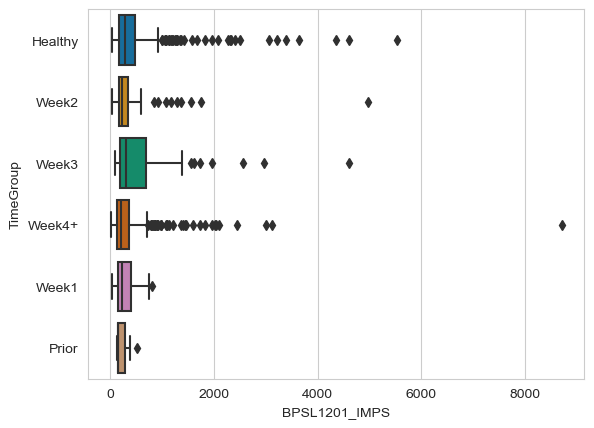

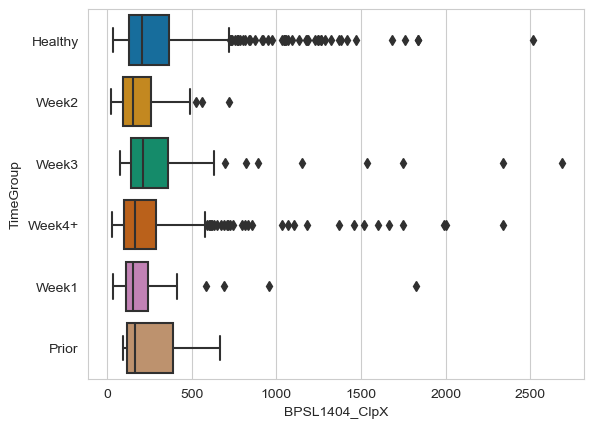

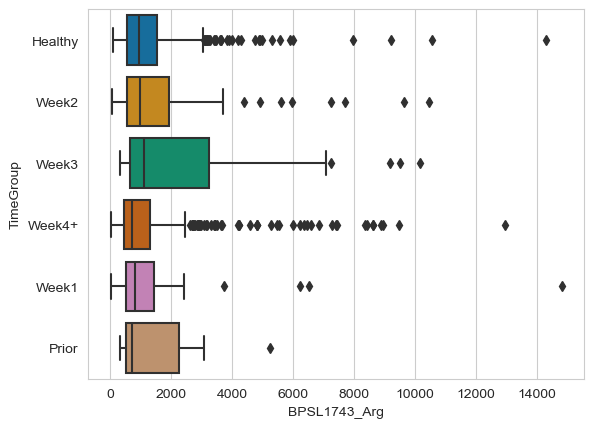

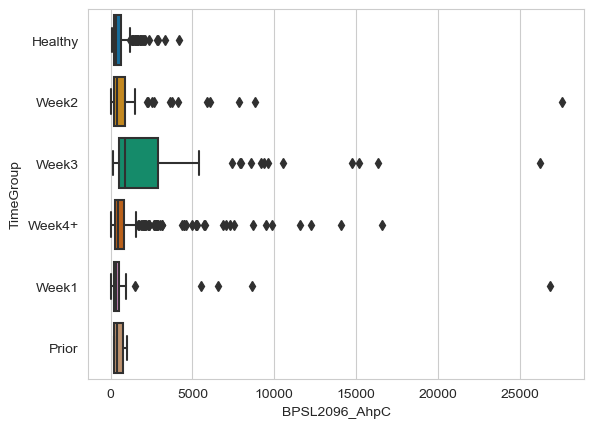

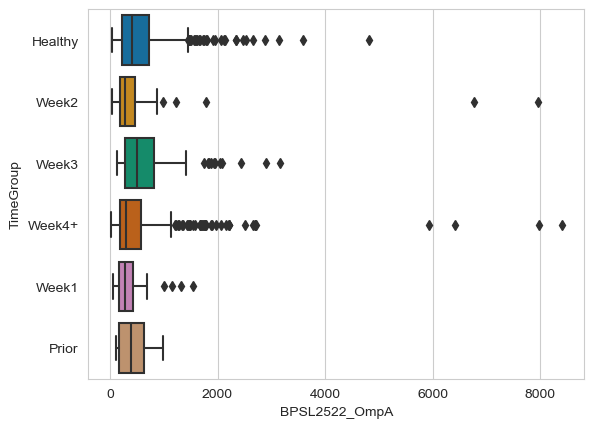

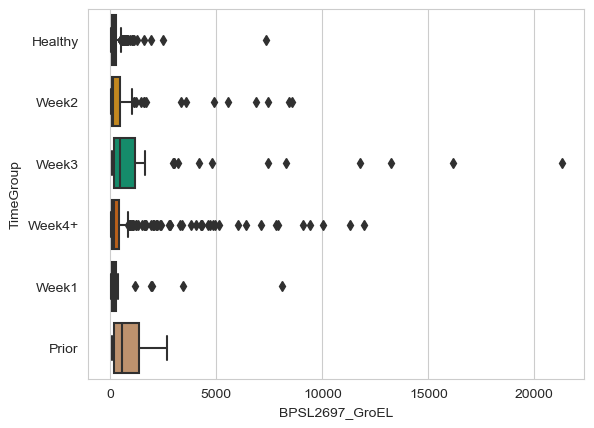

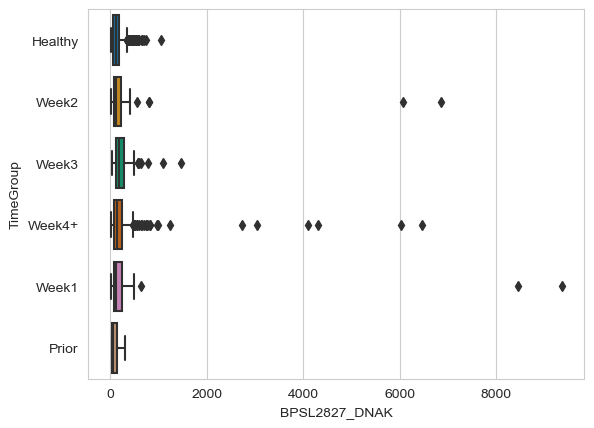

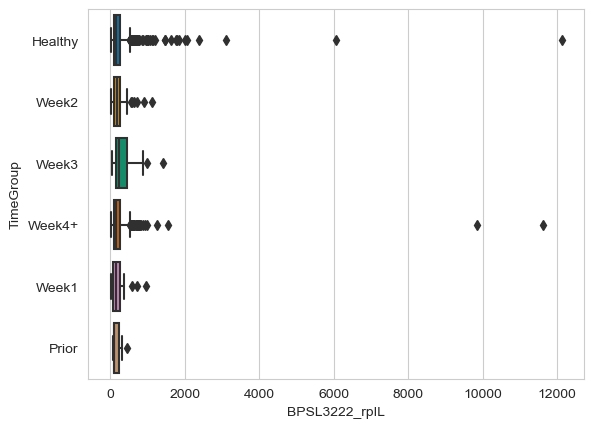

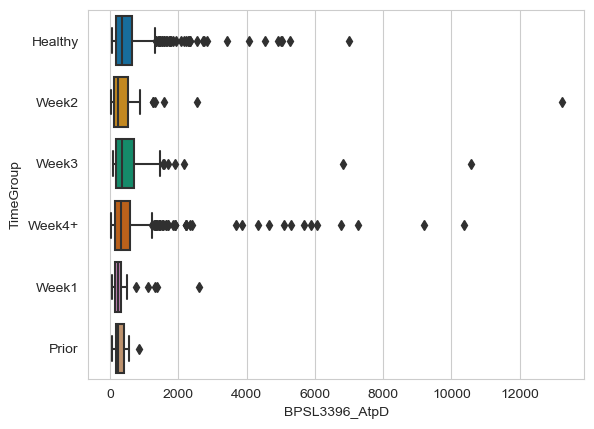

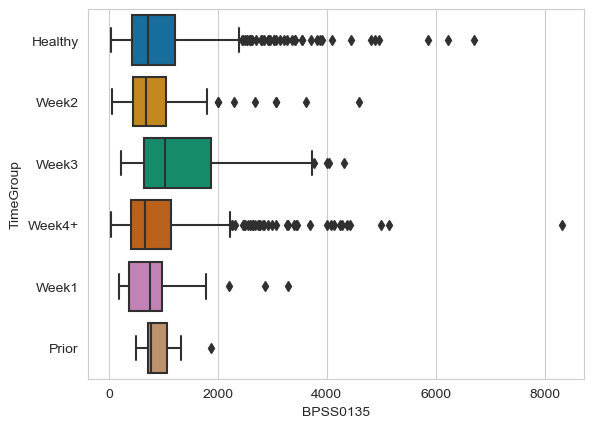

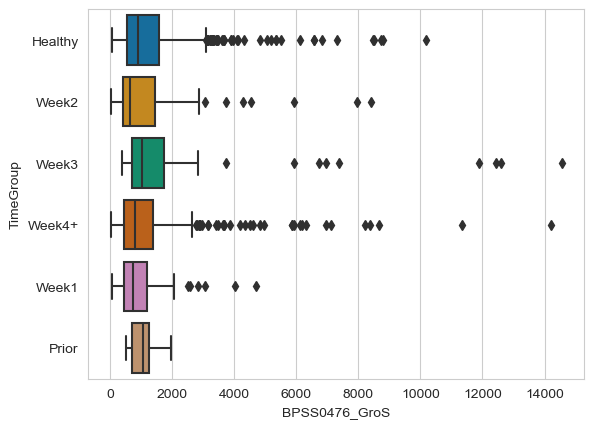

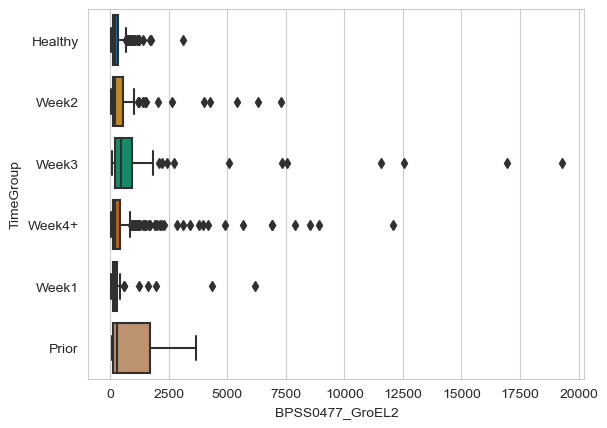

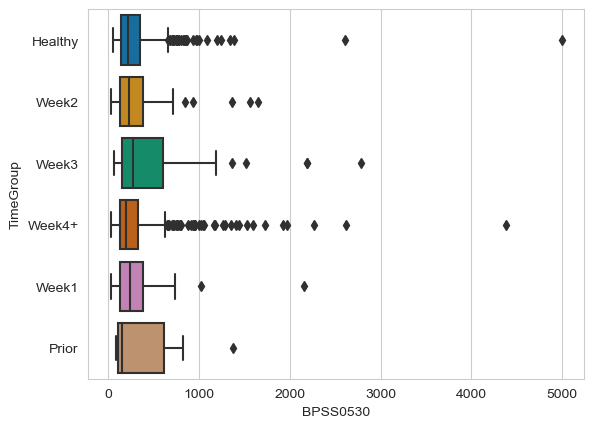

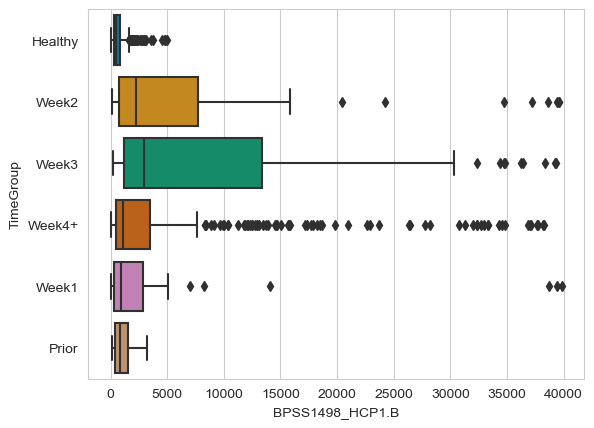

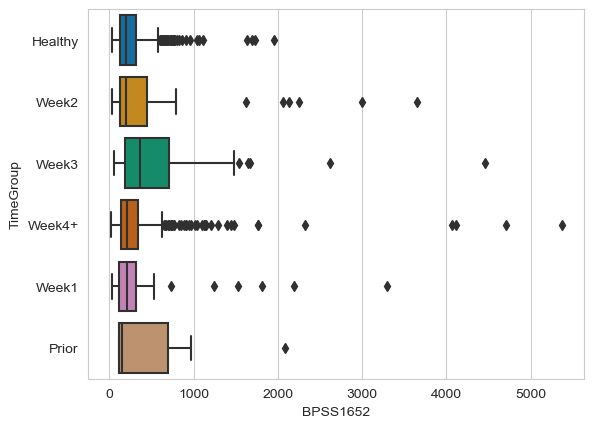

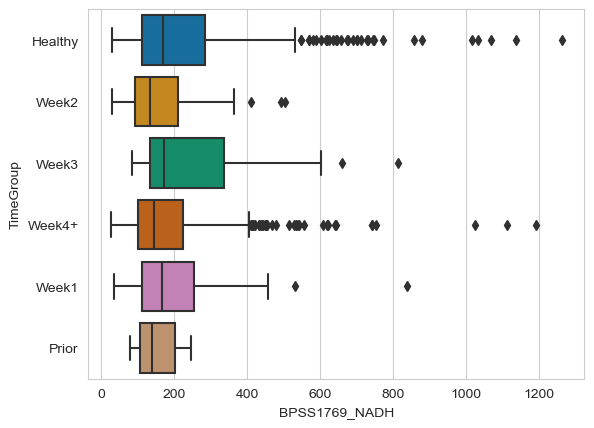

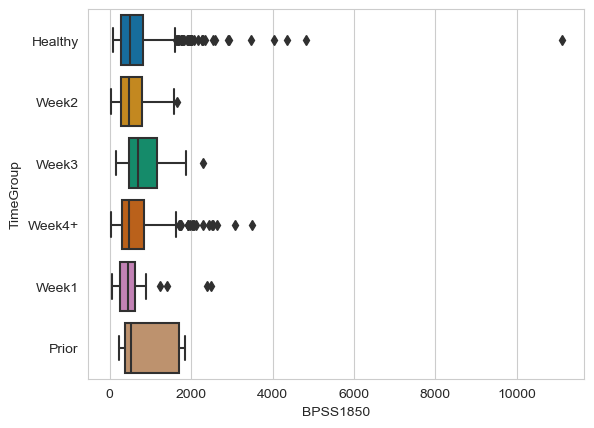

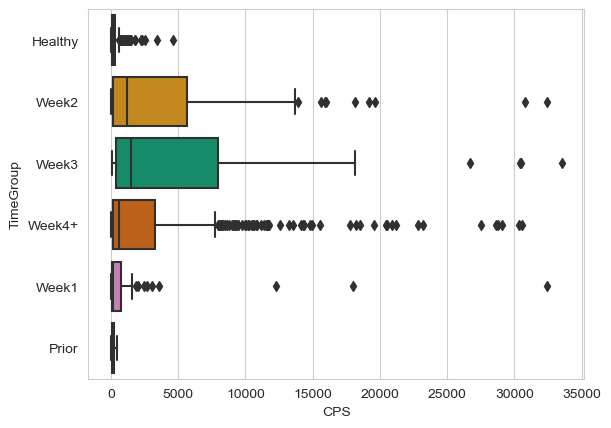

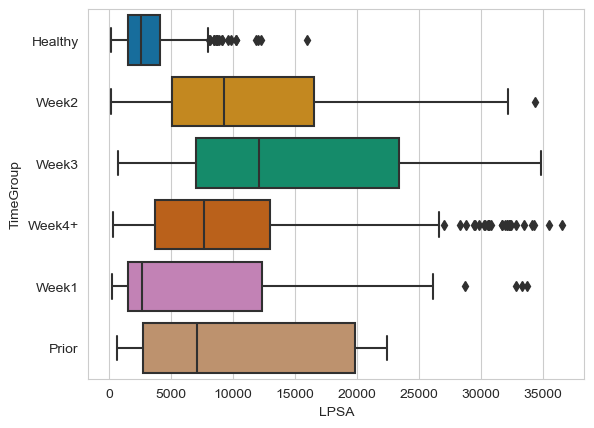

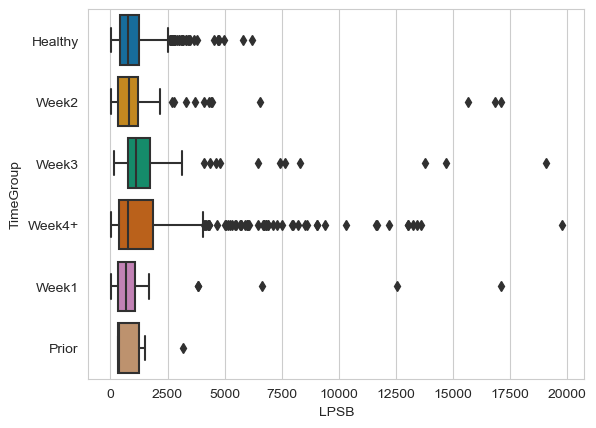

In [6]:
sns.set_style("whitegrid")
sns.set_palette('colorblind')
for col in Clean_min:
    fig,ax = plt.subplots()
    sns.boxplot(data=Clean, x=col, y='TimeGroup', ax=ax)
    plt.show()

In [ ]:
sns.pairplot(group, hue="Status", diag_kind="hist")

In [ ]:
sns.pairplot(group, hue="TimeGroup", diag_kind="hist")